### Sample loads twice for better mixing

In [1]:
# %load_ext Cython

In [2]:
%matplotlib inline
%load_ext line_profiler

In [3]:
import csv
import numba as nb 
import cython
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
import matplotlib
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import time
from line_profiler import LineProfiler
import warnings
warnings.simplefilter('always')

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [4]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

### Load Generated Synthetic Data

In [5]:
data = pd.read_csv('trace_exp_239_83.csv')
data.columns = ['0','1']
# data = data.drop(['Unnamed: 0'],axis=1)

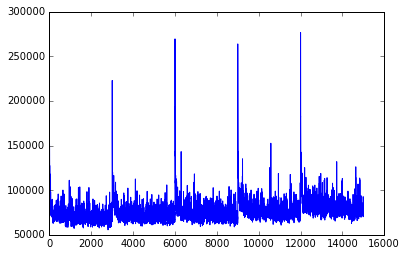

In [6]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [7]:
Wn = np.array(data['1'])
N = len(Wn)  

In [8]:
# Wn[1,N]
Wn = Wn.reshape(1,N)

In [9]:
# %%cython -f -c=-O3 -c=-march=native
# import cython
# import numpy as np
# import scipy
# cimport numpy as np
class FFBS:
#     @cython.boundscheck(False)
#     @cython.wraparound(False)
    def get_filter(self,A,pi0,pi_filter,N,F):
        A[:,0] = F[:,0]+np.log(pi0)
        #=============================================================================================
        i = 1
        A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
        #-------------------------------------------------------------------------------------
        MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1]))])
        Max = -np.max(MM)
        A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
        #--------------------------------------------------------------------------------------
        A[2,i] = F[2,i]+A[2,i-1]+np.log(pi_filter[2,2])
        #--------------------------------------------------------------------------------------
        MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
        A[3,i] = F[3,i]+np.log(np.sum(np.exp(MM)))
        #--------------------------------------------------------------------------------------                
        A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
        #--------------------------------------------------------------------------------------
        MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5]))])
        Max = -np.max(MM)
        A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
        #--------------------------------------------------------------------------------------
        A[6,i] = F[6,i]+A[6,i-1]+np.log(pi_filter[6,6])
        #--------------------------------------------------------------------------------------
        MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
        A[7,i] = F[7,i]+np.log(np.sum(np.exp(MM)))
        #=============================================================================================
        for i in range(2,N,1):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
            #--------------------------------------------------------------------------------------
            A[2,i] = F[2,i]+A[2,i-1]+np.log(pi_filter[2,2])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            Max = -np.max(MM)
            A[3,i] = F[3,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5]))])
            Max = -np.max(MM)
            A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
            #--------------------------------------------------------------------------------------
            A[6,i] = F[6,i]+A[6,i-1]+np.log(pi_filter[6,6])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            Max = -np.max(MM)
            A[7,i] = F[7,i]-Max+np.log1p(np.sum(np.exp(MM[MM!=-Max]+Max)))
        
        return A
    
    def emission_distribution(self,Wn,Sn,params,hyper_param,M,ID):
        # This is needed for the calculation of the Filter
        f = hyper_param['f']
        ind = list(range(M))
        ind.remove(ID)
        # Ksn[M,N]
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0) 
        # Ksn_filter[8]
        Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] 
        # self.rate [8,N]
        r = hyper_param['dt']*(params['rho']+np.dot(params['bm'][0,ind],Ksn[ind,:]))
        rate = [r+hyper_param['dt']*Ksn_filter[i] for i in range(2)]   

        likelihood = [((rate[0]/f)*np.log(Wn/(params['gain']*f))-scipy.special.loggamma(rate[0]/f)),
                      ((rate[1]/f)*np.log(Wn/(params['gain']*f))-scipy.special.loggamma(rate[1]/f))]
        
        d = []
        d.append(likelihood[0])
        d.append(likelihood[1])
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        # Likelihood or Emission distribution
        # F[8,N]
        F = self.emission_distribution(Wn,Sn,params,hyper_param,M,ID)     
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        # pi0[8,1]
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])    
        
        return self.get_filter(A,pi0,pi_filter,N,F)
    
    def _FFBS(self,N,pi,pi_filter,params,hyper_param,Sn,Wn):
        # States of the system considered for the filter
        M = hyper_param['N_particles']
        #Snm[8,2]
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) 
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            # A[8,N]
            A = self.Filter(pi,pi_filter,N,ID,Sn,Wn,M,params,hyper_param) 
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))        
            
            # Sampling via Gumbel distribution
            g_i = -np.log(-np.log(np.random.uniform(size=8)))
            # Get the state at the last time level
            ind_N = np.argmax(g_i+A[:,N-1])          
            # Backward Sampling
            Sn[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            # AA[4,N]
            AA = A[:4,:] if ind_N<4 else A[4:,:]                
            for n in range(N-2,-1,-1):
                weight = AA[:,n]+np.log(pi[:,Sn[ID,n+1]])
                g_i = -np.log(-np.log(np.random.uniform(size=4)))
                Sn[ID,n] = np.argmax(g_i+weight) 
          
        return bm, Sn

In [10]:
class Metropolis_Hastings:      
    def _proposal(self,x1,x2,alfa):
        # x1 refers to old and x2 refers to proposal
        return ((2*alfa-1)*(np.log(x1/x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        # x1 refers to old and x2 refers to proposal
        return (alfa-1)*np.log(x2/x1)+(x1-x2)/beta

    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):            
        f = hyper_param['f']
        Ksn1 = np.where(Sn==1,y1,0.0)  # old
        rate1 = (x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] # rate1[1,N]
        
        Ksn2 = np.where(Sn==1,y2,0.0)  # prop 
        rate2 = (x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] # rate2[1,N]
        
        # Likelihood ratio in log format
        L_final = (np.sum(scipy.special.loggamma(rate1/f)-scipy.special.loggamma(rate2/f))+
                   np.sum(np.log(Wn/f)*(rate2-rate1)/f)+
                   np.log(1./hyper_param['beta']+np.sum(Wn)/f)*(np.sum(rate1)-np.sum(rate2))/f+
                   scipy.special.loggamma(hyper_param['alfa']+np.sum(rate2)/f)-
                   scipy.special.loggamma(hyper_param['alfa']+np.sum(rate1)/f))
        
        return L_final

In [11]:
class Gibbs_sampler:  
    def update_gain(self,Wn,Ksn,params,hyper_param):
        f = hyper_param['f']
        alfa_new = hyper_param['alfa']+np.sum((params['rho']+np.dot(params['bm'][0,:],Ksn))*hyper_param['dt'])/f
        beta_new = 1.0/hyper_param['beta']+np.sum(Wn)/f
        
        return np.random.gamma(alfa_new, scale=1.0/beta_new)
    
    def update_rho_ksigma2(self,Sn,Wn,params,hyper_param,repeats,accepted,index_a,index_b):
        MH = Metropolis_Hastings()
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        if index_a==1 and index_b==1:
            rho_prop = np.random.gamma(hyper_param['alfa1_proposal'],scale=rho_old/hyper_param['alfa1_proposal'])
            k_sigma2_prop = np.random.gamma(hyper_param['alfa2_proposal'],scale=k_sigma2_old/hyper_param['alfa2_proposal'])

            proposal_ratio = (MH._proposal(rho_old,rho_prop,hyper_param['alfa1_proposal'])+
                    MH._proposal(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_proposal']))
            prior_ratio = (MH._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                 MH._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))  
            
        elif index_a==1 and index_b==0:
            rho_prop = rho_old  
            k_sigma2_prop = np.random.gamma(hyper_param['alfa2_proposal'],scale=k_sigma2_old/hyper_param['alfa2_proposal'])

            proposal_ratio = MH._proposal(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_proposal'])                   
            prior_ratio = MH._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2'])
            
        else:
            rho_prop = np.random.gamma(hyper_param['alfa1_proposal'],scale=rho_old/hyper_param['alfa1_proposal'])
            k_sigma2_prop = k_sigma2_old
            
            proposal_ratio = MH._proposal(rho_old,rho_prop,hyper_param['alfa1_proposal'])
            prior_ratio = MH._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1']) 
              
            
        likelihood_ratio = MH._likelihood(rho_old,k_sigma2_old,rho_prop,k_sigma2_prop,Sn,params,hyper_param,Wn)
        
        # Step (b)                                
        AR = likelihood_ratio+prior_ratio+proposal_ratio
        
        # Step (c)
        v = np.random.exponential(scale=1)
        
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn,M):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn[j,i]
                if Sn[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return count
    
    def update_weight_State(self,hyper_param,pi,pi_filter,params,Sn,Wn):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params,hyper_param,Sn,Wn)
    
    def likelihood_ratio(self,Wn,Sn,params,hyper_param,M,bm_old,bm_prop):
        # This is needed for the calculation of the Filter
        f = hyper_param['f']
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0) 
        rate_old = hyper_param['dt']*(params['rho']+np.dot(bm_old[0,:],Ksn))
        rate_prop = hyper_param['dt']*(params['rho']+np.dot(bm_prop[0,:],Ksn))
        
        likelihood_ratio = ((rate_prop/f-rate_old/f)*np.log(Wn)+scipy.special.loggamma(rate_old/f)
                     -scipy.special.loggamma(rate_prop/f)+(rate_old/f-rate_prop/f)*np.log(f*params['gain']))
        return np.sum(likelihood_ratio)
    
    def MH_loads(self,hyper_param,params,Sn,Wn,M,accepted,weights_loads):
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        
        bm_old = params['bm']
        bm_prop = ss.bernoulli.rvs(weights_loads).reshape(1,M)
        
        # Step (a)
        likelihood_ratio = self.likelihood_ratio(Wn,Sn,params,hyper_param,M,bm_old,bm_prop)
        
        # Step (b)                                
        AR = likelihood_ratio
        
        # Step (c)
        v = np.random.exponential(scale=1)
        
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return bm_prop, accepted 
        else:
            return bm_old, accepted 
        
    def update_weight(self,params,hyper_param,M):
        alfa = hyper_param['gama']/M
        beta = (M-1)/M
        alfa_new = alfa+params['bm']
        beta_new = 1+beta-params['bm']
        
        return np.random.beta(alfa_new, beta_new)  

In [12]:
class MH_Sn_loads:   
    def sample(self,weight):
        P = np.cumsum(weight)
        return np.searchsorted(P, np.random.uniform())
    
    #  pair = random.sample(list(itertools.permutations(list(range(M)),2)),1)[0]
    def decide_split_merge(self,Sn,params,hyper_param,merge,split,pi,pair,N):        
        bm1_old = params['bm'][0,pair[0]]
        bm2_old = params['bm'][0,pair[1]]
        
        Sn1_old = Sn[pair[0],:]
        Sn2_old = Sn[pair[1],:]
        
        d1 = dict(N=N,bm1_old=bm1_old,bm2_old=bm2_old,Sn1_old=Sn1_old,Sn2_old=Sn2_old,split=split)
        d2 = dict(N=N,bm1_old=bm1_old,bm2_old=bm2_old,Sn1_old=Sn1_old,Sn2_old=Sn2_old,pi=pi,merge=merge)
        d3 = {}
        decision_map = {(1,0):self.split1,(0,1):self.split2,(1,1):self.merge1,(0,0):self.no_merge_split}
        decision_ID = {(1,0):d1,(0,1):d1,(1,1):d2,(0,0):d3}
        
        # Decide whether to merge or split
        func = decision_map[(bm1_old,bm2_old)]
        return func(**decision_ID[(bm1_old,bm2_old)])

    def split1(self,N,bm1_old,bm2_old,Sn1_old,Sn2_old,split):
        # Here we split
        try:
            n = random.sample([i for i in range(N-1) if (Sn1_old[i]==1 and Sn1_old[i+1]==1)],1)[0]
            Sn1_prop = np.hstack([Sn1_old[:n+1],np.full([N-n-1,],3)])
            Sn2_prop = np.hstack([np.full([n+1,],0),Sn1_old[n+1:]]) 

            bm1_prop = 1
            bm2_prop = 1
            split = True
#             print('split',n,Sn1_prop[n-2:n+2],Sn2_prop[n-2:n+2])
            return bm1_old,bm2_old,bm1_prop,bm2_prop,Sn1_old,Sn2_old,Sn1_prop,Sn2_prop,'split'
        except:
            return None      
        
    def split2(self,N,bm1_old,bm2_old,Sn1_old,Sn2_old,split):
        # Here we split
        try:
            n = random.sample([i for i in range(N-1) if (Sn2_old[i]==1 and Sn2_old[i+1]==1)],1)[0]
            Sn2_prop = np.hstack([Sn2_old[:n+1],np.full([N-n-1,],3)])
            Sn1_prop = np.hstack([np.full([n+1,],0),Sn2_old[n+1:]])    
            
            bm1_prop = 1
            bm2_prop = 1  
            split = True
#             print('split',n,Sn1_prop[n-2:n+2],Sn2_prop[n-2:n+2])
            return bm1_old,bm2_old,bm1_prop,bm2_prop,Sn1_old,Sn2_old,Sn1_prop,Sn2_prop,'split'
        except:
            return None 
        
    def merge1(self,N,bm1_old,bm2_old,Sn1_old,Sn2_old,pi,merge):
        # Here we merge
        try:
            n = random.sample([i for i in range(N-1) if (((Sn1_old[i]==1 and Sn1_old[i+1]==3) and (Sn2_old[i]==0 and Sn2_old[i+1]==1))
                                                      or ((Sn2_old[i]==1 and Sn2_old[i+1]==3) and (Sn1_old[i]==0 and Sn1_old[i+1]==1)))],1)[0]  
            if (Sn1_old[n]==1 and Sn1_old[n+1]==3):
                Sn2_prop = np.hstack([Sn1_old[:n+1],Sn2_old[n+1:]])
                Sn1_prop = np.zeros(N,dtype=np.int)
                for j in range(1,N): 
                    Sn1_prop[j] = MH_Sn_loads.sample(pi[Sn1_prop[j-1]])   
                    
                bm1_prop = 0
                bm2_prop = 1
#                 print('merge',n,Sn2_prop[n-2:n+2])
                merge = True
                return bm1_old,bm2_old,bm1_prop,bm2_prop,Sn1_old,Sn2_old,Sn1_prop,Sn2_prop,'merge'
            elif (Sn2_old[n]==1 and Sn2_old[n+1]==3):
                Sn1_prop = np.hstack([Sn2_old[:n+1],Sn1_old[n+1:]])
                Sn2_prop = np.zeros(N,dtype=np.int) 
                for j in range(1,N): 
                    Sn2_prop[j] = MH_Sn_loads.sample(pi[Sn2_prop[j-1]])
                
                bm1_prop = 1
                bm2_prop = 0
#                 print('merge',n,Sn1_prop[n-2:n+2])
                merge = True
                return bm1_old,bm2_old,bm1_prop,bm2_prop,Sn1_old,Sn2_old,Sn1_prop,Sn2_prop,'merge'      
        except:
            return None
       
    def no_merge_split(self):
        return None
        
    def Get_prior_ratio(self,bm1_old,bm2_old,bm1_prop,bm2_prop,
                             Sn1_old,Sn2_old,Sn1_prop,Sn2_prop,params,hyper_param,M,N,pi):
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        load_ratio = (np.log(ss.bernoulli.pmf(bm1_prop,p1)/ss.bernoulli.pmf(bm1_old,p1))+
                      np.log(ss.bernoulli.pmf(bm2_prop,p1)/ss.bernoulli.pmf(bm2_old,p1)))
        
        c1 = self.update_Sn_prior(Sn1_old,M,N) 
        c2 = self.update_Sn_prior(Sn2_old,M,N) 
        c3 = self.update_Sn_prior(Sn1_prop,M,N) 
        c4 = self.update_Sn_prior(Sn2_prop,M,N)       
        
        traj_ratio = (np.sum((c3[pi>1e-06]+c4[pi>1e-06])*np.log(pi[pi>1e-06]))-
                      np.sum((c1[pi>1e-06]+c2[pi>1e-06])*np.log(pi[pi>1e-06])))
        
        return load_ratio+traj_ratio,c1,c2,c3,c4
    
    def Get_proposal_ratio(self,bm1_old,bm2_old,bm1_prop,bm2_prop,c1,c2,c3,c4,logic,pi):
        if logic=='split':
            if bm2_old == 0:
                proposal_ratio = np.sum(c2[pi>1e-06]*np.log(pi[pi>1e-06]))
            elif bm1_old == 0:
                proposal_ratio = np.sum(c1[pi>1e-06]*np.log(pi[pi>1e-06]))
        elif logic=='merge':
            if bm2_prop == 0:
                proposal_ratio = -np.sum(c4[pi>1e-06]*np.log(pi[pi>1e-06]))
            elif bm1_prop == 0:
                proposal_ratio = -np.sum(c3[pi>1e-06]*np.log(pi[pi>1e-06]))
                
        return proposal_ratio
    
    def update_Sn_prior(self,Sn1,M,N):
        # total number of transitions for all particles over time 
        # is (N-1)     
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for i in range(0,N-1):
            state1 = Sn1[i]
            if Sn1[i+1]==0:
                count[state1][0] += 1
            elif Sn1[i+1]==1:
                count[state1][1] += 1
            elif Sn1[i+1]==2:
                count[state1][2] += 1
            elif Sn1[i+1]==3:
                count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return np.array([[count[i][j] for j in range(4)] for i in range(4)])  
    
    def AR(self,params,hyper_param,accepted,m,m1,pi,N,M,Sn):
        merge = False
        split = False
        
        # Step (a)
        pair = (m,m1)
        out = self.decide_split_merge(Sn,params,hyper_param,merge,split,pi,pair,N)
        if not out:
            return None
        
        bm1_old=out[0];bm2_old=out[1];bm1_prop=out[2];bm2_prop=out[3];Sn1_old=out[4];Sn2_old=out[5]; \
        Sn1_prop=out[6];Sn2_prop=out[7];logic=out[8]
        
        prior_ratio,c1,c2,c3,c4 = self.Get_prior_ratio(bm1_old,bm2_old,bm1_prop,bm2_prop,Sn1_old,Sn2_old,
                                                   Sn1_prop,Sn2_prop,params,hyper_param,M,N,pi)
        proposal_ratio = self.Get_proposal_ratio(bm1_old,bm2_old,bm1_prop,bm2_prop,c1,c2,c3,c4,logic,pi)
        
        # Step (b)
        AR = prior_ratio+proposal_ratio
        
        # Step (c)
        v = np.random.exponential(scale=1)
        
        # Step (d)
        if v>-AR:
            accepted = accepted + 1
            return bm1_prop,bm2_prop,Sn1_prop,Sn2_prop,accepted 
        else:
            return None

In [13]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [14]:
def __main__(pi,Sn,Ksn,params,hyper_param):
    data1 = 'Wn_single2.h5'
    data2 = 'params_single2.h5'
    data3 = 'trajectory_single2.h5'
    data4 = 'load_single2.h5'
    
    data = dict({'B':[], 'ite':[],'E_b':[],'E_ph':[], 'gain':[]})
    M = hyper_param['N_particles']
    gibbs = Gibbs_sampler()
    MH = MH_Sn_loads()
    
    Sn1 = np.zeros(N,dtype=np.int)
    Sn2 = np.zeros(N,dtype=np.int)
    
    accepted  = 0
    accepted_rho = 0
    accepted_ksigma2 = 0
    accepted_load = 0 
    accepted_sn = 0
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        # Metropolis Hastings
        params['rho'], params['k_sigma2'], accepted = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted,1,1)
        params['rho'], params['k_sigma2'], accepted_rho = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted_rho,1,0)
        params['rho'], params['k_sigma2'], accepted_ksigma2 = gibbs.update_rho_ksigma2(Sn,Wn,params,hyper_param,repeats,accepted_ksigma2,0,1)

        # Update Gain 
        params['gain'] = 1./(gibbs.update_gain(Wn,Ksn,params,hyper_param))        

        # Update Transition Probabilities
        count = gibbs.update_pi(Sn,M)        

        state = 0 
        pi[0] = np.array(list(np.random.dirichlet((0.9+count[state][0],0.1+count[state][1])))+[0,0])
        state = 1
        pi[1] = np.array([0]+list(np.random.dirichlet((0.5+count[state][1],0.4+count[state][2],0.1+count[state][3]))))
        state = 2 
        pi[2] = np.array([0]+list(np.random.dirichlet((0.9+count[state][1],0.1+count[state][2])))+[0])
        pi[3] = np.array([0,0,0,1])
        
        pi_filter = update_pi_filter(pi)
        p = pd.concat([p,pd.DataFrame(pi)],axis=0)        
        # Sanity Check
        if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
            pass
        else:
            raise Exception('probabilities do not sum to 1')      

        print(params['gain'],params['rho'],params['k_sigma2'])
        
        # FFBS
        params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params,Sn,Wn)
        
        # MH for Sn and Loads
        for m in range(M):
            a = np.delete(np.arange(M),m)
            for m1 in a:
                out = MH.AR(params,hyper_param,accepted_sn,m,m1,pi,N,M,Sn)
                if out:
                    accepted_sn = out[4]
                    print(accepted_sn)
                    Sn[m,:] = out[2]
                    Sn[m1,:] = out[3]
                    params['bm'][0,m] = out[0]
                    params['bm'][0,m1] = out[1]
                    
        # MH for smapling all loads
#         for ii in range(30):
#             weights_loads = gibbs.update_weight(params,hyper_param,M)
#             params['bm'], accepted_load = gibbs.MH_loads(hyper_param,params,Sn,Wn,M,accepted_load,weights_loads)
                
        # Sanity Check
        if all(Sn[:,0])==0:
            pass
        else:
            raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['gain'].append(params['gain'])
        data['E_b'].append(params['rho'])
        data['E_ph'].append(params['k_sigma2'])
        data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,np.count_nonzero(params['bm']),accepted/(j+1)*100,accepted_rho/(j+1)*100
                                            ,accepted_ksigma2/(j+1)*100,accepted_load/(30*(j+1))*100)

        # Save the output
        ## MCMC Chain Parameters
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        
        ## Emission Distribution
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = (params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']*params['gain']
        
        if j%20==0:
            emission_data = pd.HDFStore(data1)
            emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
            emission_data.close()
            ## Trajectory of data
            trajectory_data = pd.HDFStore(data3)
            trajectory_data['df{}'.format(j)] = pd.DataFrame(Sn)
            trajectory_data.close()
            ## Loads 
            load_data = pd.HDFStore(data4)
            load_data['df{}'.format(j)] = pd.DataFrame(params['bm'])
            load_data.close()
            
        # Some postprocessing
#         new_data = dict({'E_b': [params['theta']*params['rho']],'E_ph': [params['theta']*params['k_sigma2']],
#                          'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,handle)
    
    # Calculate Acceptance Rate
    print ("Acceptance rate = " + str(accepted/repeats*100))
    print ("Acceptance rate rho = " + str(accepted_rho/repeats*100))
    print ("Acceptance rate ksigma2 = " + str(accepted_ksigma2/(30*repeats)*100))

    return data, p

### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [15]:
repeats = 5000

In [16]:
hyper_param = {'alfa':3.0,'alfa1_proposal':100,'alfa1_prior':2.0,'alfa2_prior':2.0,
               'alfa2_proposal':100,'N_particles':400,'gama':1.0,'dt':0.01*0.95,'f':2.0} 

In [17]:
hyper_param['beta'] = 10.0/hyper_param['alfa']
hyper_param['beta1'] = 5e+3/hyper_param['alfa1_prior']
hyper_param['beta2'] = 3e+06/hyper_param['alfa2_prior']

In [18]:
M = hyper_param['N_particles']

### Parameters to be calculated by Gibbs Sampler 

In [19]:
params = {'gain':1e+1,
          'rho':5e+3,
          'k_sigma2':3e+6,
          'bm':np.random.choice(2,size=M,p=[0.8,0.2]).reshape(1,M)}

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [20]:
# pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
# pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
# pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
# pi3 = np.array([0,0,0,1])
# pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [21]:
pi = np.array([[9.99000500e-01, 9.99000500e-04, 0.00000000e+00, 4.99666792e-07],
               [0.00000000e+00, 9.99000500e-01, 0.00000000e+00, 9.99500167e-04],
               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
               [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [22]:
pi

array([[9.99000500e-01, 9.99000500e-04, 0.00000000e+00, 4.99666792e-07],
       [0.00000000e+00, 9.99000500e-01, 0.00000000e+00, 9.99500167e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

### Initialize the trajectory of states and rate matrix

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [23]:
# Sn1 = pd.read_csv('trajectory_low_SNR_multiple.csv').drop('Unnamed: 0',axis=1).values

In [24]:
Sn = np.zeros([M,N],dtype=np.int)
Sn[:,0] = 0

In [25]:
# for i in range(10):
#     Sn[i:i+10,:] = Sn1 

In [26]:
# Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# from state zero to state one and from state one to state zero.
for i in range(M):
    for j in range(1,N):
        Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])  #Sn[M,N] 

In [27]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

### Main run

In [28]:
def plot_traces(estimated_emission_final,new_data,handle):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    push_notebook(handle=handle)

In [ ]:
if __name__ == '__main__':
    if os.path.isfile('Wn_single2.h5'):
        os.remove('Wn_single2.h5')
        os.remove('params_single2.h5')
        os.remove('trajectory_single2.h5')
        os.remove('load_single2.h5')
        
#     output_notebook()
#     source = ColumnDataSource({'E_b':[],'E_ph':[],'B':[],'ite':[]})
#     s1 = figure(width=250, plot_height=250, title=None)
#     s1.scatter(x='ite', y='B', color="navy", alpha=0.5, source=source)
#     s2 = figure(width=250, height=250, title=None)
#     s2.scatter(x='ite', y='E_b', color="firebrick", alpha=0.5, source=source)
#     s3 = figure(width=350, height=250, title=None)
#     s3.scatter(x='ite', y='E_ph', color="olive", alpha=0.5, source=source)  
#     source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
#     s4 = figure(width=350, height=250, title=None)
#     s4.scatter(x='ite', y='est', color="black", alpha=0.5, source=source1)
#     s4.scatter(range(N), Wn, color="blue", alpha=0.5) 
#     pl = gridplot([[s1,s2,s3],[s4]], toolbar_location=None)
#     handle = show(pl, notebook_handle=True, new='window', notebook_url='localhost:8888')
    
    out = __main__(pi,Sn,Ksn,params,hyper_param) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS.Filter)
#     lp.add_function(FFBS.get_filter)
#     lp.add_function(FFBS.emission_distribution)
#     lp.add_function(MH_Sn_loads.AR)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(pi,Sn,Ksn,params,hyper_param)
#     lp.print_stats() 
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

0
0.6490793800622698 5025.076489484269 2943200.8014582135
1080.7481606006622 400 100.0 100.0 0.0 0.0
1


/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expect

0.23317180761439849 5562.26863786841 2866638.608945476
1084.6393735408783 400 50.0 100.0 50.0 0.0
2
0.22964749752777844 5562.26863786841 2685215.955761925
1078.4435312747955 400 33.33333333333333 100.0 33.33333333333333 0.0
3
0.22848495568877072 4515.060625332503 2457152.5560656665
1082.1238601207733 400 25.0 100.0 50.0 0.0
4
0.22878809786289375 4724.876360478023 2342205.1699580722
1084.3438701629639 400 40.0 100.0 40.0 0.0
5
0.22780272454642697 4724.876360478023 2180326.8169606254
1088.8678426742554 400 33.33333333333333 100.0 33.33333333333333 0.0
6
0.22768340733152295 4724.876360478023 2180326.8169606254
1091.2389895915985 400 28.57142857142857 85.71428571428571 28.57142857142857 0.0
7
0.22753356386531393 3796.289777157084 1749635.3681464777
1092.1451921463013 400 37.5 87.5 37.5 0.0
8
0.2270682866667344 3672.0861151995446 1644657.5417093602
1108.1851081848145 400 44.44444444444444 77.77777777777779 33.33333333333333 0.0
9
0.2274330331879176 3672.0861151995446 1644657.5417093602
1129

### Postprocessing

In [ ]:
# %%cython -f -c=-O3 -c=-march=native
# import cython
# import numpy as np
# import scipy
# cimport numpy as np

# @cython.boundscheck(False)
# @cython.wraparound(False)
# def MH_loop(params,hyper_param, int accepted_sn,pi, int N, int M,Sn, object MH):
#     cdef int m,m1
#     cdef double out
#     cdef np.ndarray[int] a
    
#     for m in range(M):
#         a = np.delete(np.arange(M),m)
#         for m1 in a:
#             out = MH.AR(params,hyper_param,accepted_sn,m,m1,pi,N,M,Sn)
#             if out:
#                 accepted_sn = out[4]
#                 print(accepted_sn)
#                 Sn[m,:] = out[2]
#                 Sn[m1,:] = out[3]
#                 params['bm'][0,m] = out[0]
#                 params['bm'][0,m1] = out[1]

In [ ]:
data1 = 'Wn_single1.h5'
emission_data = pd.HDFStore(data1)
fig = plt.figure(figsize=(4,4)) 
    
gain = 10 
Miu_b_true = 5e+03
Miu_emission = 3e+06
# Ksn_true = np.where(Sn_true==1,Miu_emission,0.0) 
# Lambda_n = hyper_param['dt']*(Miu_b_true+Ksn_true.sum(axis=0))*gain

plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(0,100,5):
    plt.plot(range(N),emission_data['df{}'.format(i)].iloc[0])  

plt.scatter(range(N), Wn, color="blue", alpha=0.5)
# plt.scatter(range(N), Lambda_n[0,:], color="red", alpha=0.5)
plt.xlim([0,6000])
# plt.ylim([0,3000])
# plt.ylabel(ylabel)
# plt.xlabel(xlabel)
plt.tight_layout()
sns.despine(offset=10)
# fig.savefig('Emission_distribution.pdf')

In [ ]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

In [ ]:
sns_plot = sns.jointplot(x=df['ite'],y=df['gain'], kind='scatter',color='g',s =200,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
# sns_plot.ax_joint.set_ylim([0,300])

In [ ]:
h = sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)

In [ ]:
h = sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)
h.ax_joint.set_ylim([10,25])

In [ ]:
data3 = 'trajectory_single1.h5'
traj = pd.HDFStore(data3)

In [ ]:
ss = traj['df{}'.format(1900)] 

In [ ]:
data4 = 'load_single1.h5'
load = pd.HDFStore(data4) 

In [ ]:
l = load['df{}'.format(1900)]

In [ ]:
active_loads = np.where(l==1)

In [ ]:
fig, ax1 = plt.subplots()
for i in active_loads[1]:
    ax1.step(x=range(N),y=ss.iloc[i]) 

In [ ]:
fig, ax1 = plt.subplots()
for i in active_loads[1]:
    ax1.step(x=range(N),y=ss.iloc[i]) 
    
ax2 = ax1.twinx() 
ax2.scatter(range(N), Wn, color="blue", alpha=0.5)
ax2.set_ylim([0,3500000])
ax1.legend()
ax2.set_xlim([0,6000])
# ax1.set_xlim([5000,7000])

In [ ]:
sns_plot = sns.jointplot(x=df['ite'][500:],y=df['E_b'][500:], kind='scatter',color='g',s =200,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
# sns_plot.ax_joint.set_ylim([0,2000])
# sns_plot.savefig('Emission_background.pdf')

In [ ]:
sns_plot = sns.jointplot(x=df['ite'][500:],y=df['E_ph'][500:], kind='scatter',color='g',s =200,linewidth=2)
# sns_plot.ax_joint.set_ylim([0,5000])
# sns_plot.savefig('Photon_Emission.pdf')

In [ ]:
Sn_true = pd.read_csv('trajectory_low_SNR.csv').drop('Unnamed: 0',axis=1).values

step = 0.01
partitions = [i*step for i in range(round(60./step))]
t = partitions

data3 = 'trajectory_single5.h5'
traj = pd.HDFStore(data3)
    
data4 = 'load_single5.h5'
load = pd.HDFStore(data4)    
    
fig = plt.figure(figsize=(4,4)) 
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(100,2000,100):
    for ii in range(len(traj['df{}'.format(i)])):
        if load['df{}'.format(i)].iloc[0,ii]==1:
            plt.step(x=t[:-1],y=traj['df{}'.format(i)].iloc[ii]) 
        
plt.step(x=t[:-1],y=Sn_true[0,:], color="blue") 
# plt.xlim([78,84])

In [ ]:
d = ss.gamma.pdf(np.linspace(1,500,10000),hyper_param['alfa1_prior'],scale=hyper_param['beta1'])

In [ ]:
n, bins, patches = plt.hist(out[0]['E_b'], 500, facecolor='blue')
plt.plot(d*12500,color='k')
plt.xlim([0,500])
# plt.ylim([0,1])
# plt.axvline(1000, color='r')

In [ ]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+3, color='r')

In [ ]:
out1 = out[1] 
pi_true = np.array([[9.95012479e-01, 4.39321572e-03, 5.71372296e-04, 2.29327917e-05],
                    [0.00000000e+00, 7.72101222e-01, 2.19089414e-01, 8.80936423e-03],
                    [0.00000000e+00, 8.76357655e-03, 9.91190636e-01, 4.57876835e-05],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
#     fig.savefig('Probability_distribution.pdf')
    return None

In [ ]:
plot_hist(d, pi_true)